# Experiment with Data from ODDS Stony Brook

Please cite: (if you are using this work)

@inproceedings{DBLP:conf/sigkdd/Akoglu15,
author = {Shebuti Rayana and Leman Akoglu},
title = {Collective Opinion Spam Detection: Bridging Review Networks and metadata},
booktitle = {Proceeding of the 21st ACM SIGKDD international conference
on Knowledge discovery and data mining, {KDD’15}},
year = {2015},
}


## Data Dictionary

The reviewContent file contains the review text and metadata file contains meta information in the following order
 
- user_id 
- prod_id 
- rating 
- label 
- date

For feature extraction you need both files. For running the LBP you need the reviewGraph (user_id(1 .. N), prod_id(1 ... M), rating) file. The other two files are just mapping of original user_id and product_id to a unique number for reviewGraph representation. Based on this structure you might need to change some lines of code in initialization.


__Above are notes from the author of the data.__

## Data Files

Originally, there are two parts in the data:

- reviewcontents: contains the review texts
- metadata: contains the mapping to reviewer/products

Both are in `tsv` format. These are about reviews of hotels and restaurants in the Tri-state area.

I have merged the two files into `processed.csv` - which contains `358,957` reviews, from `160,201` reviewers, on `923` businesses.

The data contains two parts: _recommended_ (`label == 1`) and _filtered_ (`label == -1`) - which are based on the Yelp filtering algorithm. One important reason for Yelp to filter the reviews is that they may be _fake reviews._

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
review_df = pd.read_csv('./amazon_data_20191202/processed.csv', index_col=0)
review_df.head()

,user_id,prod_id,date,text,review_id,rating,label
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,923020141208,3.0,-1
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...,924020130516,3.0,-1
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,925020130701,4.0,-1
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...,926020110728,4.0,-1
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...,927020101101,4.0,-1


In [3]:
review_df.user_id.nunique()

160201

In [4]:
review_df.user_id.value_counts().nlargest(10)

3504    181
2980    137
976     124
5250    122
3324    119
1048    116
3459    116
3347    115
8472    114
4351    110
Name: user_id, dtype: int64

In [5]:
review_df.prod_id.value_counts().nlargest(10)

247    7378
555    6632
542    4716
465    3935
468    3143
91     3122
72     2999
668    2943
211    2848
100    2677
Name: prod_id, dtype: int64

In [6]:
review_df.prod_id.nunique()

923

In [7]:
review_df.prod_id.value_counts().nlargest(5).sum()

25804

In [8]:
review_df.prod_id.value_counts().nlargest(5).index

Int64Index([247, 555, 542, 465, 468], dtype='int64')

In [9]:
review_subset_5 = review_df[review_df.prod_id.isin(review_df.prod_id.value_counts().nlargest(5).index)]
review_subset_5.shape

(25804, 7)

## EDA

The data is somewhat imbalanced (89.73% recommended). I split them into two DFs - `rec_df` and `filter_df`.

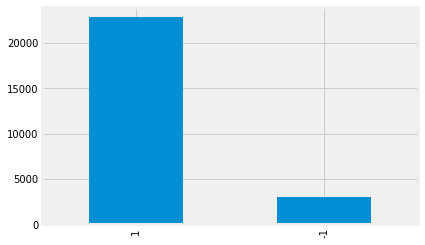

In [10]:
review_subset_5.label.value_counts().plot(kind='bar')

In [11]:
rec_df = review_subset_5[review_subset_5.label == 1]
filter_df = review_subset_5[review_subset_5.label == -1]

In [12]:
rec_df.shape, filter_df.shape

((22835, 7), (2969, 7))

## Text Preprocessing

In this version, I use `doc2vec` to represent the review texts - since it is analoguos to the PCA used to process numeric data. Each review is then projected to a real-value vector.

We should consider using `PCA` and `word2vec`, and maybe pretrained word embedding `GloVe` as baselines.

In [14]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [15]:
reviews = review_subset_5[['text', 'label']]
#reviews['label'] == -1
## we do following recoding since Doc2Vec does not allow negative tags
def recode(x):
    if x == -1:
        return 2
    else:
        return x
reviews['label'] = reviews['label'].apply(recode)
reviews = reviews.values
reviews[:2]

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([['Staff and service is horrible. \xa0Food is expensive. Cash only.',
        2],
       ['Was very disappointed with the pizza. It was cold and was bland.. I waited 2 hours \xa0outside just to be seated. \xa0The prices were reasonable and so was the canoli. Would not be going back ever again',
        2]], dtype=object)

In [16]:
for rev in reviews:
    print(rev[0], rev[1])
    break

Staff and service is horrible.  Food is expensive. Cash only. 2


This shows the tokens as the first argument which are _tokens_ and _label_ as the second argument (`-1/1`) for `TaggedDocument`.

In [17]:
tagged_docs = [TaggedDocument(words=word_tokenize(r[0].lower()), tags=[r[1]]) 
               for r in reviews]

In [18]:
type(tagged_docs)

list

Save `tagged_docs` to disk so that we can reuse it.

In [19]:
import pickle

with open('./amazon_data_20191202/tagged_docs-20191205.pkl', 'wb') as f:
    pickle.dump(tagged_docs, f)

## Checkpoint 1: Saved Tagged Documents

If want to re-train the _Doc2Vec_ model, start here.

In [20]:
import pickle
with open('./amazon_data_20191202/tagged_docs-20191205.pkl', 'rb') as f:
    tagged_docs = pickle.load(f)

These hyperparameters are suggested by previous analyses.

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [22]:
#cores = multiprocessing.cpu_count()
max_epochs = 20
#vec_size = 20
alpha = 0.025

model_dbow = Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, 
                     workers=25, alpha=alpha, min_alpha=0.00025)
model_dbow.build_vocab(tagged_docs)

Other studies suggest training between 10 - 20 epochs.

In [23]:
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model_dbow.train(tagged_docs,
                total_examples=model_dbow.corpus_count,
                epochs=model_dbow.epochs) # use model_dbow.epochs instead
    # decrease the learning rate
    model_dbow.alpha -= 0.0002
    # fix the learning rate, no decay
    #model_dbow.min_alpha = model_dbow.alpha
    
model_dbow.save('./models/model.d2v')

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


Saving and reading the model `model_dbow` to local so next time do not have to train again.

## Checkpoint 2: Saved Doc2Vec Model

If want to used the trained `Doc2Vec` model, start here.

In [24]:
import gensim
d2v_model = gensim.models.doc2vec.Doc2Vec.load('./models/model.d2v')

In [25]:
def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=100)) for doc in sents])
    return targets, feature_vectors

In [26]:
tags, features = vector_for_learning(d2v_model, tagged_docs)

In [29]:
with open('./amazon_data_20191202/features-20191205.pkl', 'wb') as f1:
    pickle.dump(features, f1)
    
    
with open('./amazon_data_20191202/tags-20191205.pkl', 'wb') as f2:
    pickle.dump(tags, f2)

Need to convernt tags and features to a DF so we can use following code.

In [30]:
import pickle

with open('./amazon_data_20191202/features-20191205.pkl', 'rb') as f1:
    features = pickle.load(f1)
    
with open('./amazon_data_20191202/tags-20191205.pkl', 'rb') as f2:
    tags = pickle.load(f2)

In [31]:
type(tags), type(features)

(tuple, tuple)

In [32]:
tags[:2]

(2, 2)

In [33]:
len(features)

25804

In [34]:
len(tags)

25804

In [35]:
import pandas as pd
tags_col = pd.DataFrame(tags)
tags_col.head()

,0
0,2
1,2
2,2
3,2
4,2


In [36]:
features_df = pd.DataFrame(features)
features_df.shape

(25804, 300)

In [37]:
data = pd.concat([features_df, tags_col], axis=1)
data.shape

(25804, 301)

In [38]:
cols = ['w' + str(i) for i in range(300)]
cols[:2]

['w0', 'w1']

In [39]:
len(cols)

300

In [40]:
cols.append('label')
cols[-1]

'label'

In [41]:
data.columns = cols

In [42]:
data.label = data.label.apply(lambda x: abs(x-2))

### Split Data

Note: only used recommended reviews (label == 1) to train AEs.

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data, test_size=0.2, random_state=2019)
X_train = X_train[X_train.label == 1]
X_train = X_train.drop(['label'], axis=1)
y_test = X_test['label']
X_test = X_test.drop(['label'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape, X_test.shape, y_test.shape

((18283, 300), (5161, 300), (5161,))

# Basic AutoEncoder

In [79]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers

In [80]:
input_dim = X_train.shape[1]
encoding_dim = 256
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [81]:
nb_epoch = 100
batch_size = 256

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard, es]).history

Train on 18283 samples, validate on 5161 samples
Epoch 1/100
18283/18283 [==============================] - 1s 68us/step - loss: 5.1767 - acc: 0.0557 - val_loss: 4.4212 - val_acc: 0.1128
Epoch 2/100
18283/18283 [==============================] - 1s 30us/step - loss: 3.8426 - acc: 0.1362 - val_loss: 2.9569 - val_acc: 0.1664
Epoch 3/100
18283/18283 [==============================] - 1s 29us/step - loss: 2.3631 - acc: 0.1665 - val_loss: 1.8530 - val_acc: 0.1535
Epoch 4/100
18283/18283 [==============================] - 1s 30us/step - loss: 1.7880 - acc: 0.1442 - val_loss: 1.6890 - val_acc: 0.1482
Epoch 5/100
18283/18283 [==============================] - 1s 31us/step - loss: 1.7161 - acc: 0.1510 - val_loss: 1.6636 - val_acc: 0.1593
Epoch 6/100
18283/18283 [==============================] - 1s 31us/step - loss: 1.6924 - acc: 0.1641 - val_loss: 1.6415 - val_acc: 0.1579
Epoch 7/100
18283/18283 [==============================] - 1s 28us/step - loss: 1.6694 - acc: 0.1867 - val_loss: 1.6192 - v

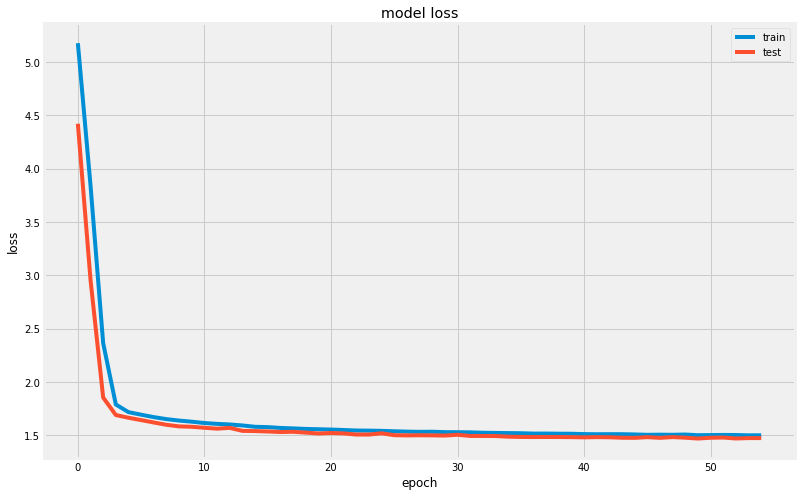

In [82]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [83]:
predictions = autoencoder.predict(X_test)

In [84]:
import numpy as np

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [85]:
error_df.describe()

,reconstruction_error,true_class
count,5161.000000,5161.00000
mean,1.364880,0.88200
std,0.673953,0.32264
min,0.018757,0.00000
25%,0.852101,1.00000
50%,1.354631,1.00000
75%,1.856449,1.00000
max,4.272813,1.00000


In [86]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

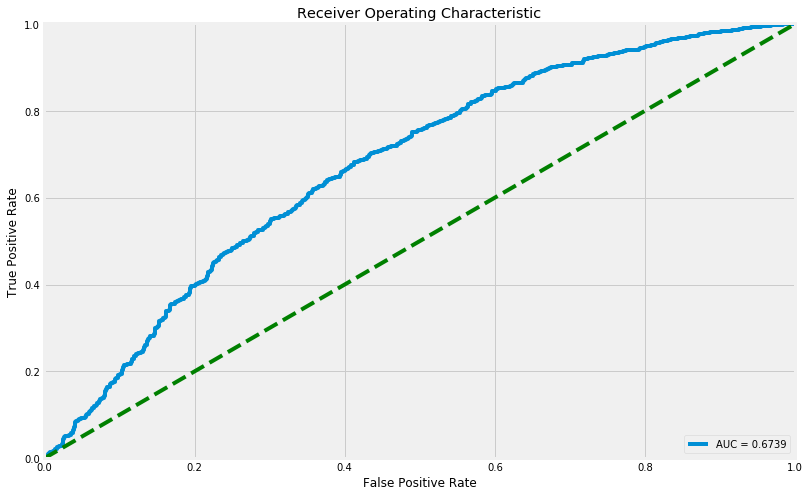

In [87]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

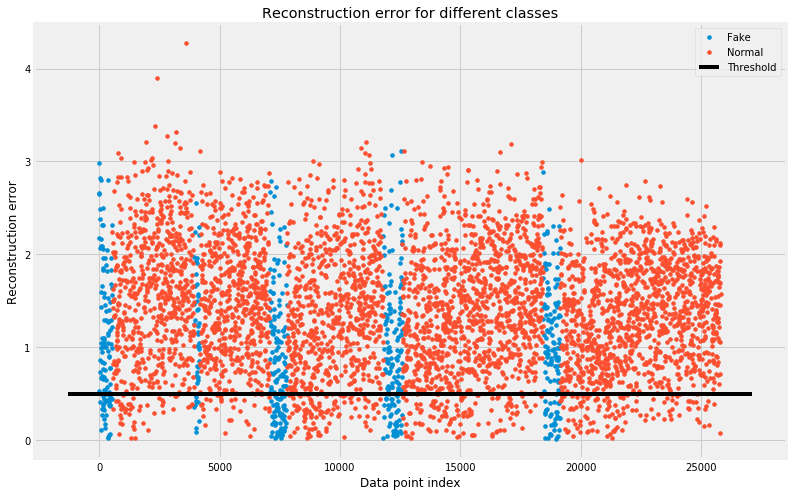

In [89]:
threshold = 0.5

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Fake")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="black", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

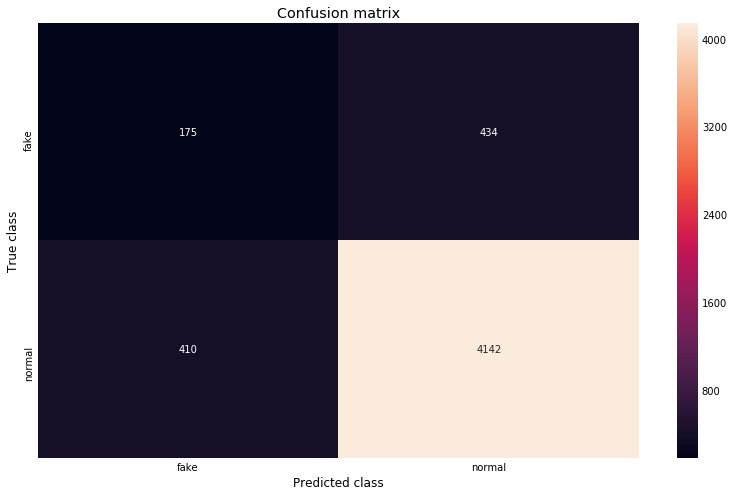

In [90]:
import seaborn as sns
labels = ['fake', 'normal']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [91]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [93]:
from keras.layers import RepeatVector, TimeDistributed
#input_dim = X_train_reshaped.shape[1]
encoding_dim = 256
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
encoder = LSTM(encoding_dim, activation="relu", return_sequences=True,
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
#encoder = LSTM(int(encoding_dim/2), activation="relu", return_sequences=True,
                #activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = LSTM(int(encoding_dim/4), activation="relu", return_sequences=False)(encoder)
L3 = RepeatVector(X_train_reshaped.shape[1])(encoder)
decoder = LSTM(int(encoding_dim/4), activation='relu', return_sequences=True)(L3)
#decoder = LSTM(int(encoding_dim/2), activation='relu', return_sequences=True)(decoder)
decoder = LSTM(encoding_dim, activation='relu', return_sequences=True)(decoder)
output = TimeDistributed(Dense(X_train_reshaped.shape[2]))(decoder)
lstm_ae = Model(inputs=input_layer, outputs=output)

lstm_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1, 300)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 1, 256)            570368    
_________________________________________________________________
lstm_26 (LSTM)               (None, 64)                82176     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
lstm_28 (LSTM)               (None, 1, 256)            328704    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 300)            77100     
Total para

In [94]:
nb_epoch = 100
batch_size = 128

lstm_ae.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

hist1 = lstm_ae.fit(X_train_reshaped, X_train_reshaped,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_reshaped, X_test_reshaped),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard,es]).history

Train on 18283 samples, validate on 5161 samples
Epoch 1/100
18283/18283 [==============================] - 6s 306us/step - loss: 1.6432 - acc: 0.0229 - val_loss: 1.4445 - val_acc: 0.0279
Epoch 2/100
18283/18283 [==============================] - 3s 177us/step - loss: 1.4872 - acc: 0.0320 - val_loss: 1.4444 - val_acc: 0.0279
Epoch 3/100
18283/18283 [==============================] - 3s 175us/step - loss: 1.4858 - acc: 0.0335 - val_loss: 1.4352 - val_acc: 0.0279
Epoch 4/100
18283/18283 [==============================] - 3s 176us/step - loss: 1.4674 - acc: 0.0326 - val_loss: 1.3804 - val_acc: 0.0380
Epoch 5/100
18283/18283 [==============================] - 3s 172us/step - loss: 1.3995 - acc: 0.0429 - val_loss: 1.3514 - val_acc: 0.0469
Epoch 6/100
18283/18283 [==============================] - 3s 173us/step - loss: 1.3850 - acc: 0.0562 - val_loss: 1.3289 - val_acc: 0.0651
Epoch 7/100
18283/18283 [==============================] - 3s 169us/step - loss: 1.3601 - acc: 0.0719 - val_loss: 1.3

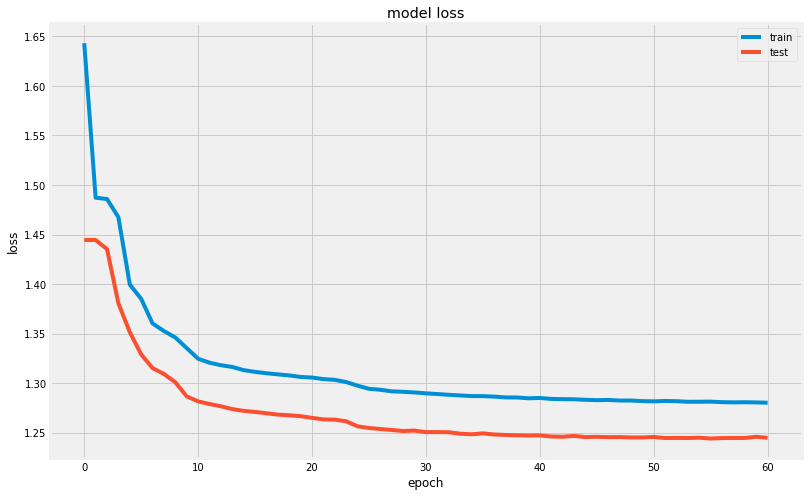

In [95]:
plt.figure(figsize=(12,8))
plt.plot(hist1['loss'])
plt.plot(hist1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [96]:
predictions = lstm_ae.predict(X_test_reshaped)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[2])

In [97]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [98]:
error_df.describe()

,reconstruction_error,true_class
count,5161.000000,5161.00000
mean,1.241293,0.88200
std,0.664513,0.32264
min,0.010501,0.00000
25%,0.718728,1.00000
50%,1.233557,1.00000
75%,1.741286,1.00000
max,4.471797,1.00000


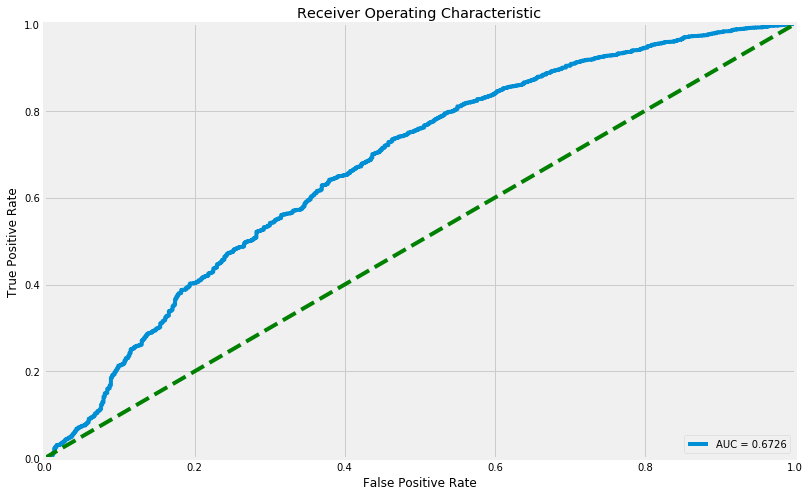

In [99]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

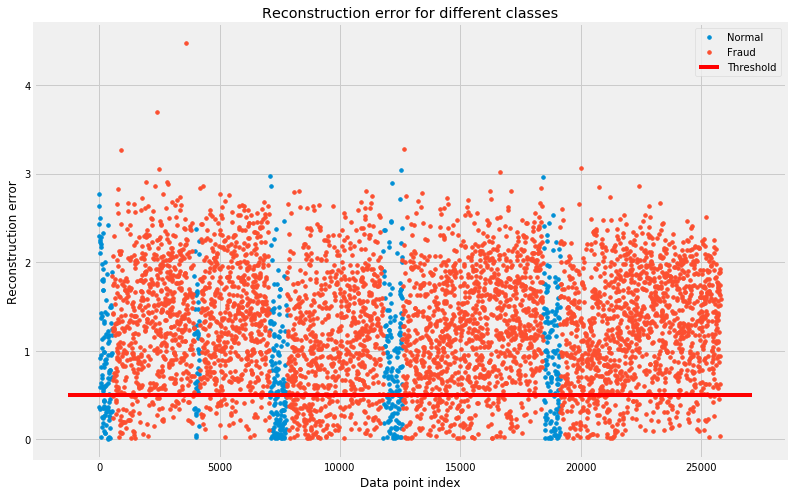

In [100]:
threshold = 0.5

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12,8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

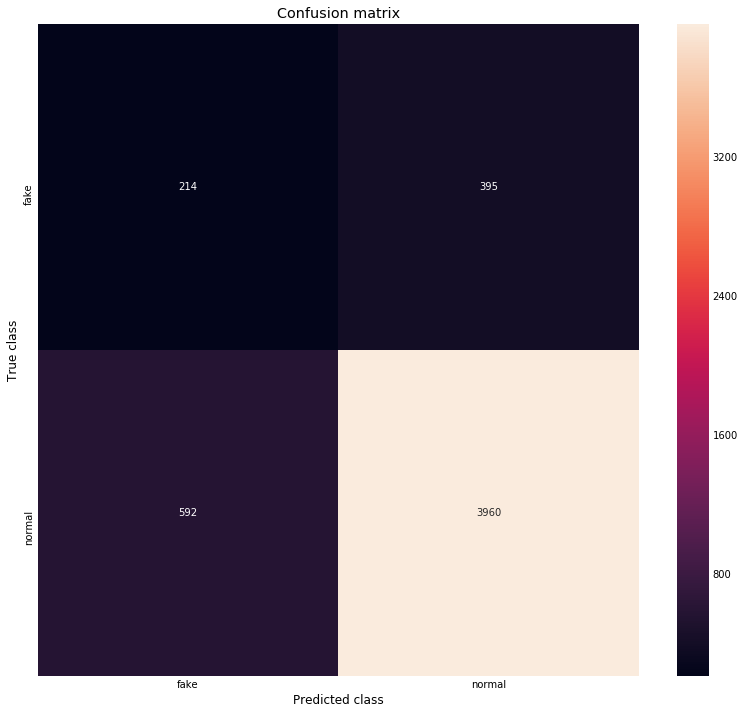

In [101]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
from keras.layers import Conv1D, MaxPool1D, UpSampling1D
encoding_dim = 256
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
encoder = LSTM(encoding_dim, activation="relu", return_sequences=True,
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
#encoder = LSTM(int(encoding_dim/2), activation="relu", return_sequences=True,
                #activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = LSTM(int(encoding_dim/4), activation="relu", return_sequences=False)(encoder)
L3 = RepeatVector(X_train_reshaped.shape[1])(encoder)
decoder = LSTM(int(encoding_dim/4), activation='relu', return_sequences=True)(L3)
#decoder = LSTM(int(encoding_dim/2), activation='relu', return_sequences=True)(decoder)
decoder = LSTM(encoding_dim, activation='relu', return_sequences=True)(decoder)
output = TimeDistributed(Dense(X_train_reshaped.shape[2]))(decoder)
lstm_ae = Model(inputs=input_layer, outputs=output)

lstm_ae.summary()